In [1]:
import scanpy as sc
import anndata as ad
import squidpy as sq

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

READ THE DATA

In [1]:
bm_sp = sc.read_visium("../BMN/data/V11B18-363_B1/")

NameError: name 'sc' is not defined

In [8]:
bm_sp
#bm_sp.uns["spatial"]
#bm_sp.uns[spatial][library_id]


AnnData object with n_obs × n_vars = 811 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [12]:
bm_sp.obs["in_tissue"]

AAACAAGTATCTCCCA-1    1
AAACCGGGTAGGTACC-1    1
AAACCTCATGAAGTTG-1    1
AAACTTGCAAACGTAT-1    1
AAAGACTGGGCGCTTT-1    1
                     ..
TTGGACCATCTGGCAA-1    1
TTGGCTCGCATGAGAC-1    1
TTGTAAGGACCTAAGT-1    1
TTGTTAGCAAATTCGA-1    1
TTGTTTCCATACAACT-1    1
Name: in_tissue, Length: 811, dtype: int64

In [10]:
bm_sp.obs

,in_tissue,array_row,array_col
AAACAAGTATCTCCCA-1,1,50,102
AAACCGGGTAGGTACC-1,1,42,28
AAACCTCATGAAGTTG-1,1,37,19
AAACTTGCAAACGTAT-1,1,45,19
AAAGACTGGGCGCTTT-1,1,29,15
...,...,...,...
TTGGACCATCTGGCAA-1,1,51,105
TTGGCTCGCATGAGAC-1,1,23,37
TTGTAAGGACCTAAGT-1,1,46,32
TTGTTAGCAAATTCGA-1,1,22,42


In [97]:
bm_sp.var_names_make_unique()
bm_sp.var["mt"] = bm_sp.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(bm_sp, qc_vars=["mt"], inplace=True)

QC AND PREPROCESS

/Users/medinils/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

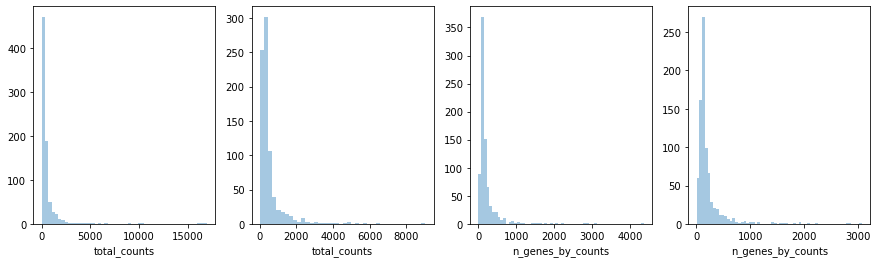

In [98]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(bm_sp.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(bm_sp.obs["total_counts"][bm_sp.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(bm_sp.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(bm_sp.obs["n_genes_by_counts"][bm_sp.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [99]:
#sc.pp.filter_cells(bm_sp, min_counts=100)
#sc.pp.filter_cells(bm_sp, max_counts=2500)
#print(f"#cells after MT filter: {bm_sp.n_obs}")

NORMALIZE

In [100]:
sc.pp.normalize_total(bm_sp, inplace=True)
sc.pp.log1p(bm_sp)
sc.pp.highly_variable_genes(bm_sp, flavor="seurat", n_top_genes=2000)

MANIFOLD EMBEDDING AND CLUSTERING 

In [111]:
sc.pp.pca(bm_sp)
sc.pp.neighbors(bm_sp,n_neighbors=20, n_pcs=20)
sc.tl.umap(bm_sp,min_dist= 0.7, spread=0.7, n_components=5)
sc.tl.leiden(bm_sp, key_added="clusters")

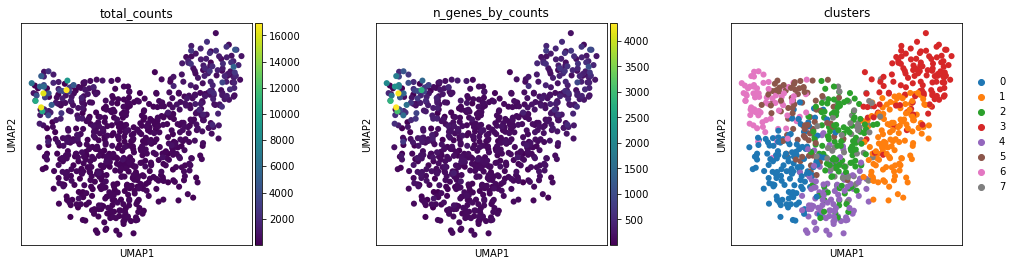

In [112]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(bm_sp, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

Visualization in spatial coordinates

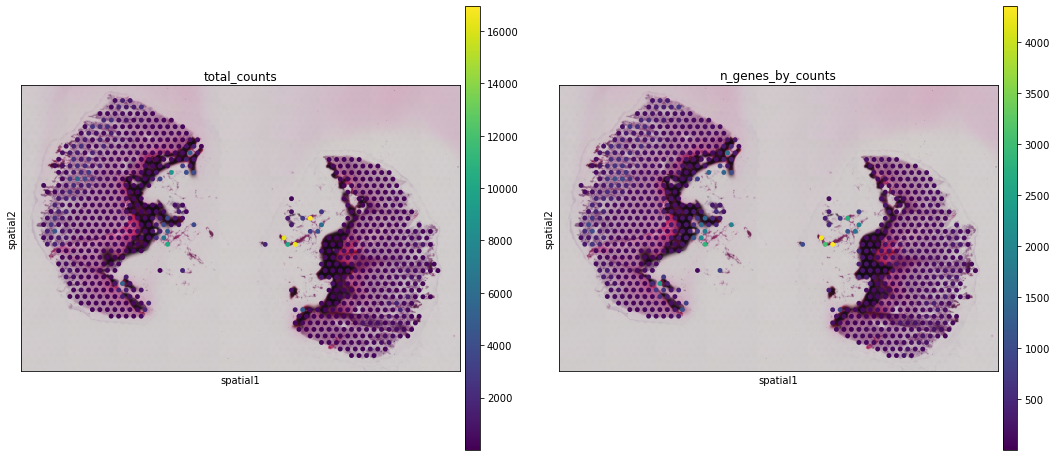

In [113]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(bm_sp, img_key="hires", color=["total_counts", "n_genes_by_counts"])

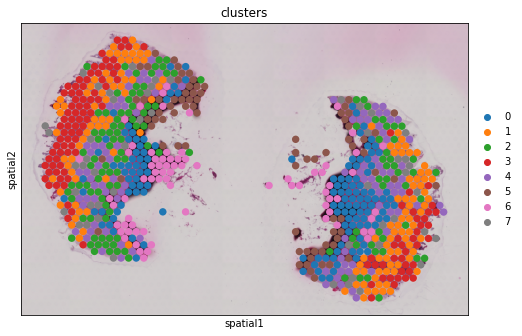

In [114]:
sc.pl.spatial(bm_sp, img_key="hires", color="clusters", size=1.5,alpha_img=0.)

CELL TO CELL

In [115]:
res = sq.gr.ligrec(
    bm_sp,
    n_perms=1000,
    cluster_key="clusters",
    copy=True,
    use_raw=False,
    transmitter_params={"categories": "ligand"},
    receiver_params={"categories": "receptor"},
)

  0%|          | 0/1000 [00:00<?, ?permutation/s]

In [116]:
res["metadata"].head()


aspect_intercell_source aspect_intercell_target  \
source target                                                   
EPOR   TRPC3               functional              functional   
       JAK2                functional              functional   
FYN    JAK2                functional              functional   
CCL2   JAK2                functional              functional   
KIT    JAK2                functional              functional   

              category_intercell_source category_intercell_target  \
source target                                                       
EPOR   TRPC3                     ligand                  receptor   
       JAK2                      ligand                  receptor   
FYN    JAK2                      ligand                  receptor   
CCL2   JAK2                      ligand                  receptor   
KIT    JAK2                      ligand                  receptor   

              category_source_intercell_source  \
source target                                    
EPOR   TRPC3                 resource_specific   
       JAK2                  resource_specific   
FYN    JAK2                  resource_specific   
CCL2   JAK2                  resource_specific   
KIT    JAK2                  resource_specific   

              category_source_intercell_target  consensus_direction  \
source target                                                         
EPOR   TRPC3                 resource_specific                 True   
       JAK2                  resource_specific                False   
FYN    JAK2                  resource_specific                False   
CCL2   JAK2                  resource_specific                 True   
KIT    JAK2                  resource_specific                 True   

               consensus_inhibition  consensus_score_intercell_source  \
source target                                                           
EPOR   TRPC3                  False                                 1   
       JAK2                   False                                 1   
FYN    JAK2                   False                                 2   
CCL2   JAK2                   False                                18   
KIT    JAK2                   False                                 1   

               consensus_score_intercell_target  ...  scope_intercell_source  \
source target                                    ...                           
EPOR   TRPC3                                  3  ...                 generic   
       JAK2                                   1  ...                 generic   
FYN    JAK2                                   1  ...                 generic   
CCL2   JAK2                                   1  ...                 generic   
KIT    JAK2                                   1  ...                 generic   

               scope_intercell_target secreted_intercell_source  \
source target                                                     
EPOR   TRPC3                  generic                      True   
       JAK2                   generic                      True   
FYN    JAK2                   generic                     False   
CCL2   JAK2                   generic                      True   
KIT    JAK2                   generic                     False   

              secreted_intercell_target  \
source target                             
EPOR   TRPC3                      False   
       JAK2                       False   
FYN    JAK2                       False   
CCL2   JAK2                       False   
KIT    JAK2                       False   

                                              sources  \
source target                                           
EPOR   TRPC3                                     TRIP   
       JAK2              BioGRID;HPRD;SignaLink3;Wang   
FYN    JAK2                    HPRD;PhosphoPoint;Wang   
CCL2   JAK2                                      Wang   
KIT    JAK2    CancerCellMap;HPRD;NetP

/Users/medinils/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:122: UserWarning: Over 500 categories found. Plot would be very large.
  warn(


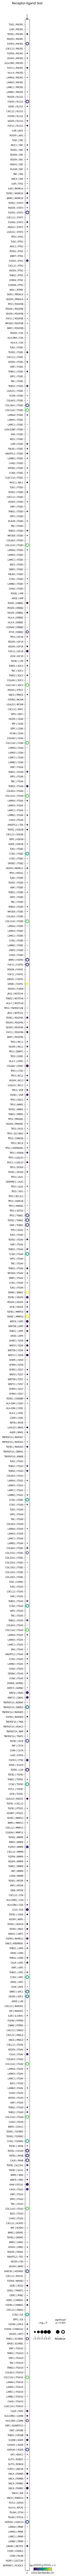

In [119]:
sq.pl.ligrec(res, cluster_key= "3,1" ,source_groups ="1",target_groups ="3",remove_empty_interactions=True,alpha=0.005)

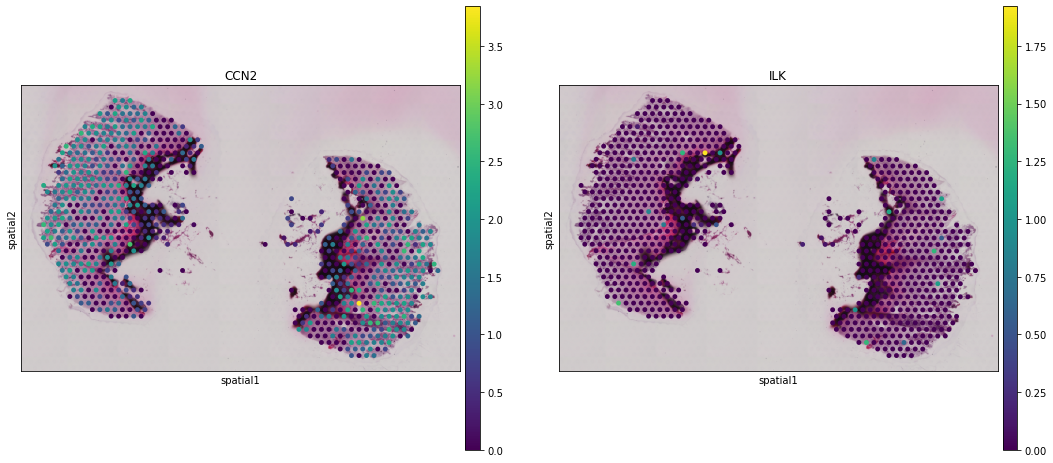

In [124]:
sc.pl.spatial(bm_sp, img_key="hires", color=["CCN2", "ILK"])

SEPAL

In [123]:
sq.gr.spatial_neighbors(bm_sp)
#genes = bm_sp.var_names[(bm_sp.var.n_cells > 100) & bm_sp.var.highly_variable][0:100]
sq.gr.sepal(bm_sp, max_neighs=6, n_jobs=1)


  0%|          | 0/2000 [00:00<?, ?/s]

,sepal_score
CYP2R1,29.969
NOTCH3,29.871
MAML3,29.848
HSD17B8,29.757
DELE1,29.719
TTC7B,29.702
MGP,29.659
CLASP2,29.588
UQCC3,29.530
KPNA5,29.481


In [145]:
#a = bm_sp[bm_sp.uns['sepal_score'].between(20, 30)]
a = bm_sp.uns['sepal_score']
a.iloc[130:150]

#sns.distplot(bm_sp.uns["sepal_score"])

,sepal_score
COG2,23.588
CHCHD2,23.577
LPCAT1,23.530
PLXDC2,23.465
KXD1,23.431
PEX11G,23.395
AJUBA,23.385
SHC1,23.273
EPHX1,23.262
GDI1,23.184


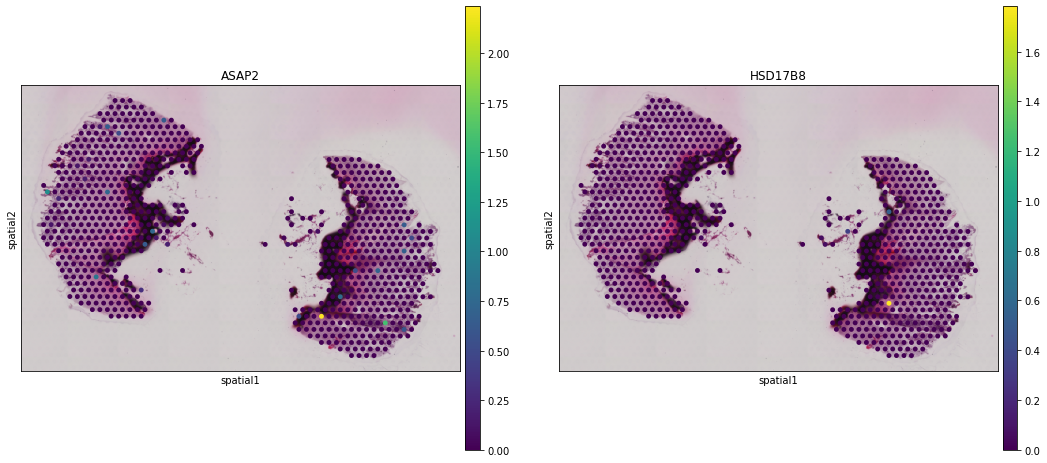

In [146]:
sc.pl.spatial(bm_sp, img_key="hires", color=["ASAP2", "HSD17B8"])